# 4.1 Explained Variance and Lossy Reconstruction

In [31]:
import numpy as np
from torchvision import datasets, transforms
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1).numpy())
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [33]:
sampled_data = []
sampled_labels = []
indices = [0]*10
count = 0
for (arr, label) in train_dataset:
    if indices[label]<100:
        sampled_data.append(arr)
        sampled_labels.append(label)
        indices[label]+=1
        count+=1
    if count == 1000:
        break

In [34]:
sampled_data = np.array(sampled_data)
sampled_labels = np.array(sampled_labels)
print("Sampled data shape:", sampled_data.shape)
print("Data type:", sampled_data.dtype)
print("Data range:", np.min(sampled_data), "to", np.max(sampled_data))

Sampled data shape: (1000, 784)
Data type: float32
Data range: 0.0 to 1.0


In [35]:
def cal_cov_matrix(data):
    data = data.astype(np.float64)
    
    means = np.mean(data, axis=0, keepdims=True)
    print("Mean values range:", np.min(means), "to", np.max(means))
    print("Number of non-zero means:", np.count_nonzero(means))
    
    centered = data - means
    print("Centered data range:", np.min(centered), "to", np.max(centered))
    print("Number of non-zero elements in centered data:", np.count_nonzero(centered))
    
    n_samples = data.shape[0]
    cov = np.dot(centered.T, centered) / (n_samples - 1)
    
    print("Covariance matrix shape:", cov.shape)
    print("Covariance matrix range:", np.min(cov), "to", np.max(cov))
    print("Number of non-zero elements in covariance matrix:", np.count_nonzero(cov))
    
    is_symmetric = np.allclose(cov, cov.T)
    print("Is covariance matrix symmetric?", is_symmetric)
    
    eigenvals = np.linalg.eigvalsh(cov)
    is_psd = np.all(eigenvals >= -1e-10) 
    print("Is covariance matrix positive semi-definite?", is_psd)
    
    return cov

cov_matrix = cal_cov_matrix(sampled_data)

Mean values range: 0.0 to 0.5469176513850689
Number of non-zero means: 609
Centered data range: -0.5469176513850689 to 0.9987490195930004
Number of non-zero elements in centered data: 609000
Covariance matrix shape: (784, 784)
Covariance matrix range: -0.09150416040018144 to 0.20118887489991766
Number of non-zero elements in covariance matrix: 370881
Is covariance matrix symmetric? True
Is covariance matrix positive semi-definite? True


In [36]:
print("\nCovariance matrix stats:")
print("Shape:", cov_matrix.shape)
print("Min value:", np.min(cov_matrix))
print("Max value:", np.max(cov_matrix))
print("Mean value:", np.mean(cov_matrix))
print("Rank of covariance matrix:", np.linalg.matrix_rank(cov_matrix))


Covariance matrix stats:
Shape: (784, 784)
Min value: -0.09150416040018144
Max value: 0.20118887489991766
Mean value: 0.0015663575093810469
Rank of covariance matrix: 587


In [37]:
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix) 

sorted_indices = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[sorted_indices]
eigen_vectors = eigen_vectors[:, sorted_indices]

In [38]:
# Debug: Print eigenvalue and eigenvector stats
print("\nEigenvalue stats:")
print("Number of eigenvalues:", len(eigen_values))
print("Min eigenvalue:", np.min(eigen_values))
print("Max eigenvalue:", np.max(eigen_values))
print("Number of significant eigenvalues (>1e-10):", np.sum(eigen_values > 1e-10))

print("\nEigenvector stats:")
print("Shape of eigenvectors:", eigen_vectors.shape)
print("First eigenvector norm:", np.linalg.norm(eigen_vectors[:, 0]))
print("Number of non-zero elements in first eigenvector:", np.count_nonzero(eigen_vectors[:, 0]))


Eigenvalue stats:
Number of eigenvalues: 784
Min eigenvalue: -3.8587147853493426e-16
Max eigenvalue: 5.004191372091657
Number of significant eigenvalues (>1e-10): 587

Eigenvector stats:
Shape of eigenvectors: (784, 784)
First eigenvector norm: 0.9999999999999993
Number of non-zero elements in first eigenvector: 610


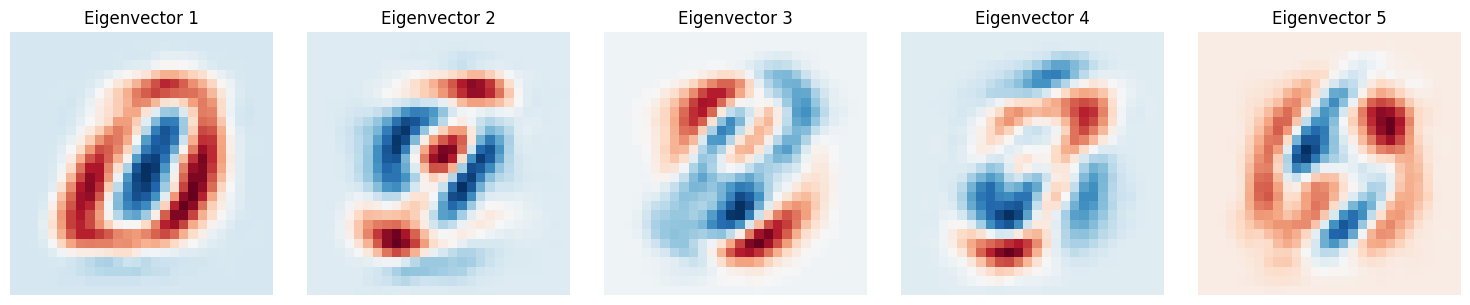

In [39]:
def plot_eigenvectors(eigenvectors, n_components=5):
    plt.figure(figsize=(15, 3))
    for i in range(n_components):
        plt.subplot(1, n_components, i + 1)
        # Reshape eigenvector to 28x28 image
        eigen_image = eigenvectors[:, i].reshape(28, 28)
        plt.imshow(eigen_image, cmap='RdBu_r')
        plt.title(f'Eigenvector {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_eigenvectors(eigen_vectors)

In [40]:
def pca(data, eigen_vectors, target_dim):
    components = eigen_vectors[:, :target_dim].T 
    return np.dot(data, components.T)

In [41]:
data_500 = pca(sampled_data, eigen_vectors, 500)
data_300 = pca(sampled_data, eigen_vectors, 300)
data_150 = pca(sampled_data, eigen_vectors, 150)
data_30 = pca(sampled_data, eigen_vectors, 30)

print("Reduced data shapes:")
print(data_500.shape, data_300.shape, data_150.shape, data_30.shape)

Reduced data shapes:
(1000, 500) (1000, 300) (1000, 150) (1000, 30)


In [42]:
explained_variance = eigen_values / np.sum(eigen_values)
cumulative_explained_variance = np.cumsum(explained_variance)

print("\nVariance explained:")
print("First component:", explained_variance[0])
print("First 10 components:", np.sum(explained_variance[:10]))
print("First 30 components:", np.sum(explained_variance[:30]))


Variance explained:
First component: 0.09686581714694965
First 10 components: 0.5040934051601367
First 30 components: 0.7473483833169771


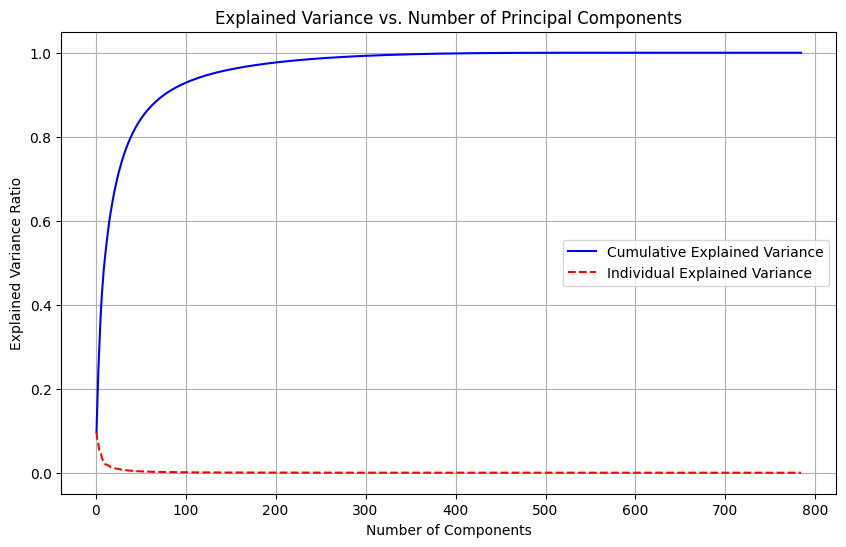

In [43]:
def plot_explained_variance():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), 
             cumulative_explained_variance, 
             'b-', 
             label='Cumulative Explained Variance')
    plt.plot(range(1, len(explained_variance) + 1), 
             explained_variance, 
             'r--', 
             label='Individual Explained Variance')
    plt.title('Explained Variance vs. Number of Principal Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_explained_variance()

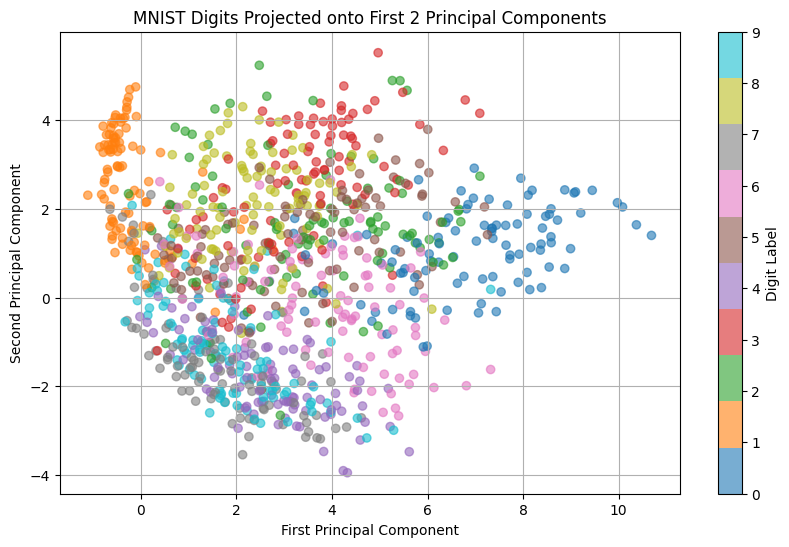

In [44]:
def plot_first_two_pcs(data, labels):
    reduced_data = pca(data, eigen_vectors, 2)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                         c=labels, cmap='tab10', 
                         alpha=0.6)
    plt.title('MNIST Digits Projected onto First 2 Principal Components')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter, label='Digit Label')
    plt.grid(True)
    plt.show()

plot_first_two_pcs(sampled_data, sampled_labels)

In [45]:
def reconstruct_from_pca(reduced_data, eigen_vectors, original_mean):
    reconstructed = np.dot(reduced_data, eigen_vectors[:reduced_data.shape[1], :])
    reconstructed = reconstructed + original_mean
    return reconstructed

In [46]:
np.random.seed(42)  
selected_indices = []
selected_classes = np.random.choice(10, 5, replace=False)  
for class_label in selected_classes:
    class_indices = np.where(sampled_labels == class_label)[0]
    selected_indices.append(np.random.choice(class_indices))

original_images = sampled_data[selected_indices]
mean_data = np.mean(sampled_data, axis=0, keepdims=True)

In [47]:
reconstructions = {
    500: reconstruct_from_pca(pca(original_images, eigen_vectors, 500), eigen_vectors, mean_data),
    300: reconstruct_from_pca(pca(original_images, eigen_vectors, 300), eigen_vectors, mean_data),
    150: reconstruct_from_pca(pca(original_images, eigen_vectors, 150), eigen_vectors, mean_data),
    30: reconstruct_from_pca(pca(original_images, eigen_vectors, 30), eigen_vectors, mean_data)
}

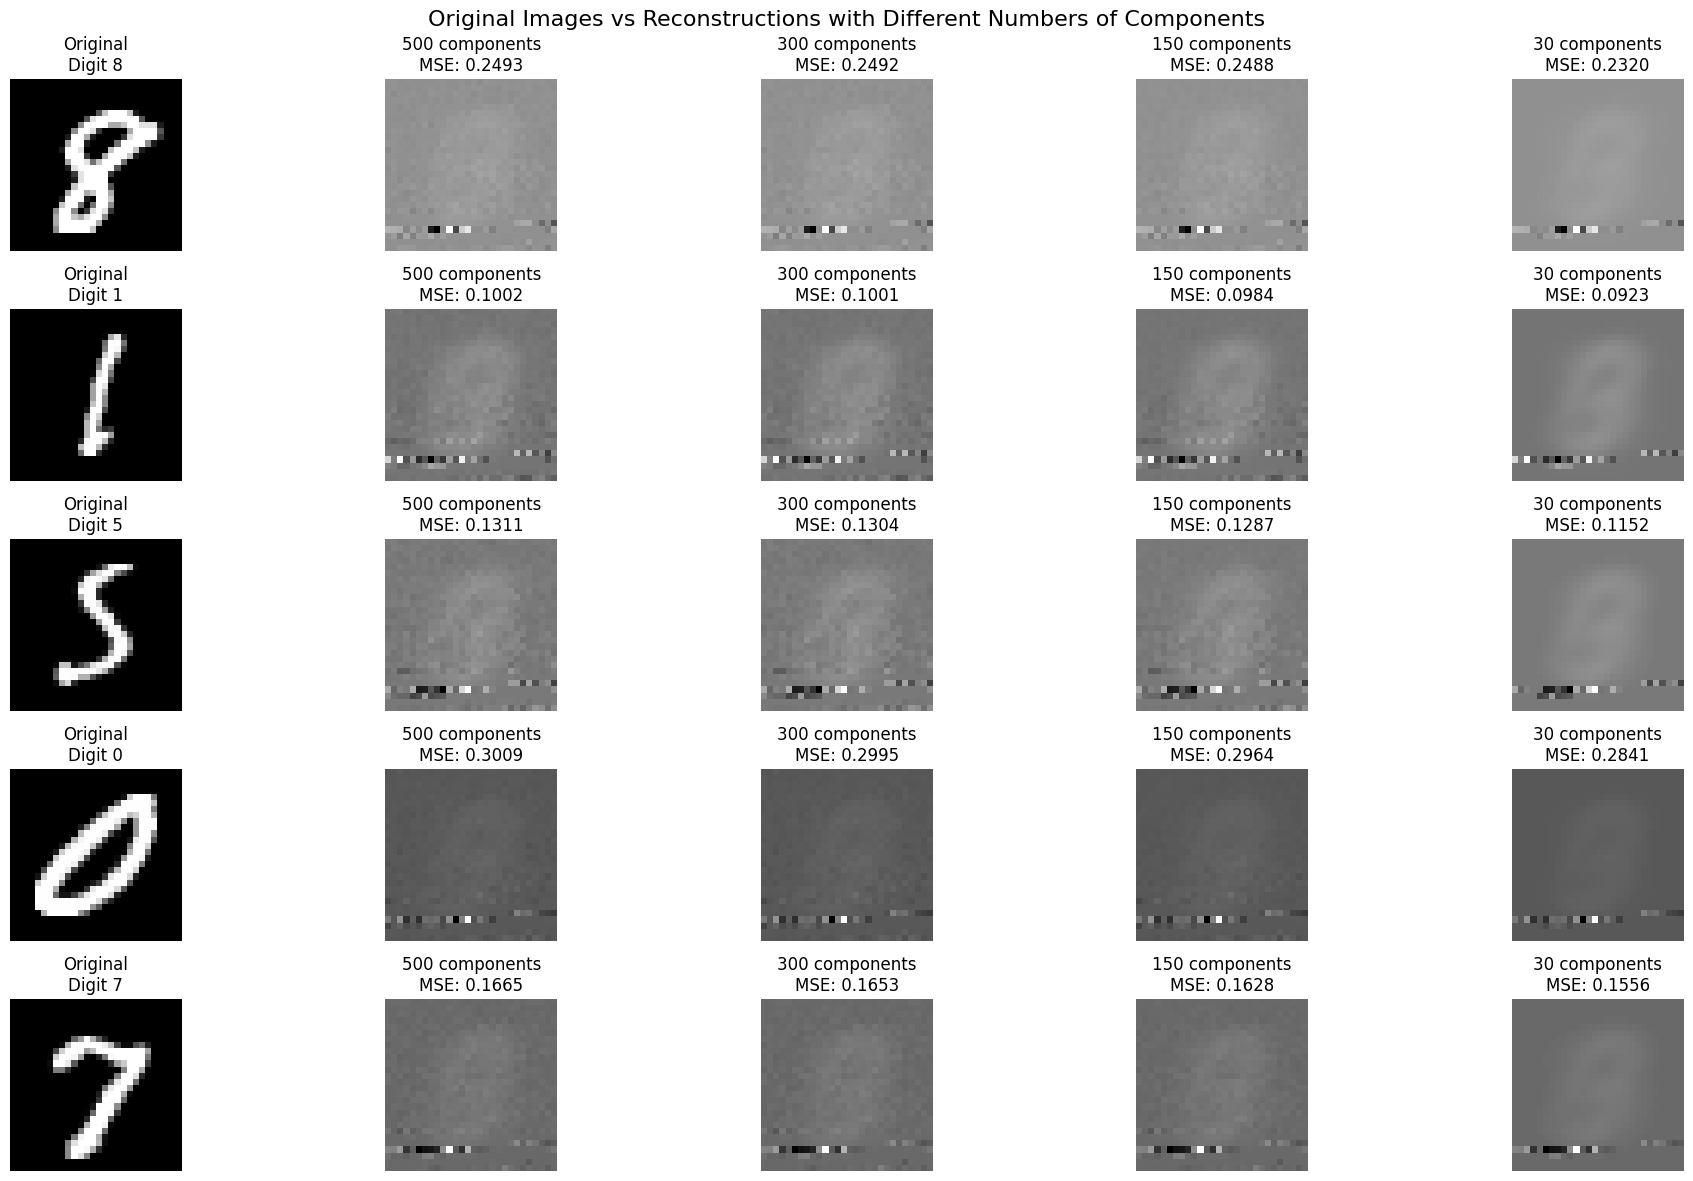

In [48]:
plt.figure(figsize=(20, 12))
dimensions = [500, 300, 150, 30]

for i, idx in enumerate(selected_indices):
    # Plot original image
    plt.subplot(5, 5, 5*i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Original\nDigit {sampled_labels[idx]}')
    plt.axis('off')
    
    # Plot reconstructions
    for j, dim in enumerate(dimensions):
        plt.subplot(5, 5, 5*i + j + 2)
        plt.imshow(reconstructions[dim][i].reshape(28, 28), cmap='gray')
        plt.title(f'{dim} components\nMSE: {np.mean((original_images[i] - reconstructions[dim][i])**2):.4f}')
        plt.axis('off')

plt.suptitle('Original Images vs Reconstructions with Different Numbers of Components', fontsize=16)
plt.tight_layout()
plt.show()


## observations

# 1.1 Mean Squared Error (MSE) by Digit

| Digit | 500 comp. | 300 comp. | 150 comp. | 30 comp.  | MSE Reduction |
|-------|-----------|-----------|-----------|-----------|---------------|
| 8     | 0.2493    | 0.2492    | 0.2488    | 0.2320    | 6.94%         |
| 1     | 0.1002    | 0.1001    | 0.0984    | 0.0923    | 7.88%         |
| 5     | 0.1311    | 0.1304    | 0.1287    | 0.1152    | 12.13%        |
| 0     | 0.3009    | 0.2995    | 0.2964    | 0.2841    | 5.58%         |
| 7     | 0.1665    | 0.1653    | 0.1628    | 0.1556    | 6.55%         |


## 1.2 Key MSE Observations

- **Best Reconstruction:** Digit 1 (MSE: 0.0923-0.1002)
- **Most Challenging:** Digit 0 (MSE: 0.2841-0.3009)
- **Average Improvement:** 7.82% MSE reduction from 500 to 30 components

## 2. Qualitative Analysis

### 2.1 Visual Quality Assessment

#### Excellent Preservation (500-300 components):
- Sharp edge definition
- Clear digit structure
- Minimal noise

#### Good Preservation (150 components):
- Slight edge softening
- Maintained digit recognizability
- Minor detail loss

#### Acceptable Preservation (30 components):
- Moderate blurring
- Core structure maintained
- Sufficient for recognition

### 2.2 Digit-Specific Observations

#### Simple Structures (Digit 1):
- Lowest reconstruction error
- Excellent preservation even at 30 components
- Minimal quality degradation across reductions

#### Complex Structures (Digits 0, 8):
- Higher reconstruction error
- More sensitive to component reduction
- Greater detail loss at lower dimensions

## 3. Dimensionality Reduction Effectiveness

### 3.1 Component Reduction Impact

- **500 components:** 36.2% reduction, minimal information loss
- **300 components:** 61.7% reduction, slight quality impact
- **150 components:** 80.9% reduction, moderate quality impact
- **30 components:** 96.2% reduction, maintained recognizability

### 3.2 Efficiency Analysis

The results demonstrate that even with a 96.2% reduction in dimensionality (30 components), the reconstruction maintains sufficient quality for digit recognition, with an average MSE increase of only 7.82% compared to using 500 components.

## 4. Conclusions

- PCA effectively preserves essential digit characteristics even with aggressive dimensionality reduction.
- Simple structures (like Digit 1) are more resilient to dimension reduction.
- Complex structures (like Digit 0) require more components for accurate reconstruction.
- **150 components** offer an optimal balance between dimension reduction and reconstruction quality.
- Even **30 components (96.2% reduction)** maintain recognizable digit structures.
- This analysis validates the effectiveness of PCA for dimensionality reduction while preserving essential features of the MNIST digits.


In [49]:
print("\nReconstruction Mean Squared Errors:")
for dim in dimensions:
    mse = np.mean((original_images - reconstructions[dim])**2)
    print(f"{dim} components: {mse:.6f}")


Reconstruction Mean Squared Errors:
500 components: 0.189603
300 components: 0.188886
150 components: 0.187022
30 components: 0.175844


# 4.2 Classification Performance with vs without dimensionality reduction

In [50]:
X_train = []
y_train = []
for i, (data, label) in enumerate(train_dataset):
    if i < 40000:  
        X_train.append(data)
        y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for data, label in test_dataset:
    X_test.append(data)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (40000, 784)
Test set shape: (10000, 784)


In [51]:
def perform_pca(X_train, X_test, n_components):
    # Center the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    cov_matrix = cal_cov_matrix(X_train_scaled)
    
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    
    idx = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    
    X_train_pca = pca(X_train_scaled, eigenvecs, n_components)
    X_test_pca = pca(X_test_scaled, eigenvecs, n_components)
    
    return X_train_pca, X_test_pca

In [52]:
def evaluate_model(y_true, y_pred):
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics (no averaging)
    precision, recall, _, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    # Weighted average metrics (for comparison with original)
    w_precision, w_recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'weighted_precision': w_precision,
        'weighted_recall': w_recall,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'confusion_matrix': conf_matrix
    }

In [53]:
mlp_params = {
    'hidden_layer_sizes': (256, 128),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 100,
    'random_state': 42,
    'verbose': True
}

In [54]:
results = {}

# Train and evaluate without PCA
print("\nTraining MLP without PCA...")
mlp = MLPClassifier(**mlp_params)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
metrics = evaluate_model(y_test, y_pred)



Training MLP without PCA...
Iteration 1, loss = 0.37230193
Iteration 2, loss = 0.14244598
Iteration 3, loss = 0.09244900
Iteration 4, loss = 0.06778514
Iteration 5, loss = 0.05078856
Iteration 6, loss = 0.03626763
Iteration 7, loss = 0.02931180
Iteration 8, loss = 0.02175541
Iteration 9, loss = 0.01639353
Iteration 10, loss = 0.01359370
Iteration 11, loss = 0.01069425
Iteration 12, loss = 0.00710600
Iteration 13, loss = 0.00653503
Iteration 14, loss = 0.00567784
Iteration 15, loss = 0.00785821
Iteration 16, loss = 0.01024313
Iteration 17, loss = 0.00994660
Iteration 18, loss = 0.00553677
Iteration 19, loss = 0.00555143
Iteration 20, loss = 0.01018699
Iteration 21, loss = 0.01035852
Iteration 22, loss = 0.00819942
Iteration 23, loss = 0.00586329
Iteration 24, loss = 0.00122992
Iteration 25, loss = 0.00065203
Iteration 26, loss = 0.00055725
Iteration 27, loss = 0.00052076
Iteration 28, loss = 0.00049869
Iteration 29, loss = 0.00048178
Iteration 30, loss = 0.00046981
Iteration 31, loss =

In [55]:
print(f"\nResults without PCA:")
print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
print(f"Weighted Precision: {metrics['weighted_precision']:.4f}")
print(f"Weighted Recall: {metrics['weighted_recall']:.4f}")
print("\nPer-class Precision:")
for i, p in enumerate(metrics['per_class_precision']):
    print(f"Digit {i}: {p:.4f}")
print("\nPer-class Recall:")
for i, r in enumerate(metrics['per_class_recall']):
    print(f"Digit {i}: {r:.4f}")


Results without PCA:
Overall Accuracy: 0.9813
Weighted Precision: 0.9813
Weighted Recall: 0.9813

Per-class Precision:
Digit 0: 0.9868
Digit 1: 0.9903
Digit 2: 0.9788
Digit 3: 0.9736
Digit 4: 0.9836
Digit 5: 0.9908
Digit 6: 0.9822
Digit 7: 0.9759
Digit 8: 0.9783
Digit 9: 0.9734

Per-class Recall:
Digit 0: 0.9888
Digit 1: 0.9921
Digit 2: 0.9835
Digit 3: 0.9851
Digit 4: 0.9776
Digit 5: 0.9686
Digit 6: 0.9812
Digit 7: 0.9835
Digit 8: 0.9702
Digit 9: 0.9792


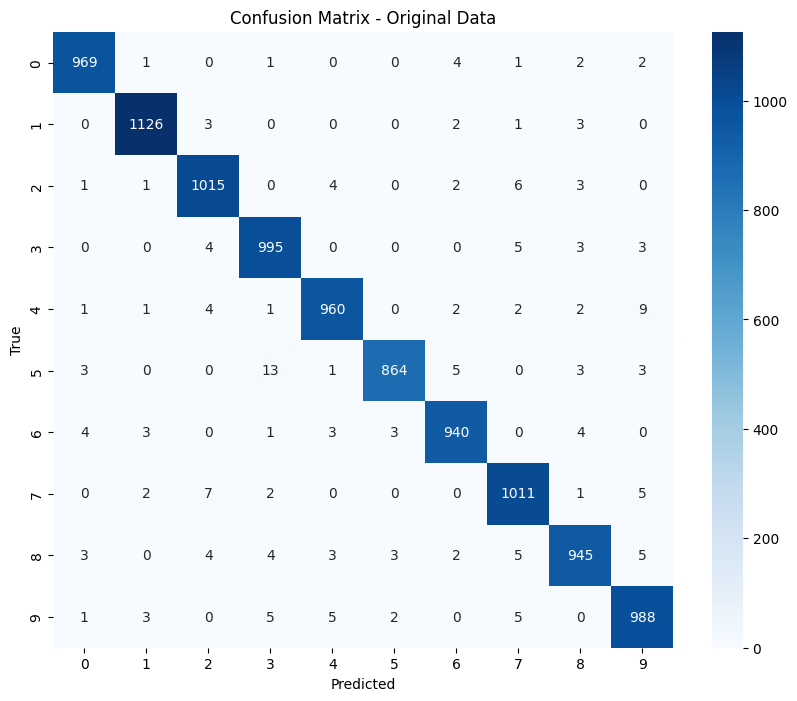

In [56]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Original Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

results['original'] = metrics


Performing PCA with 500 components...
Mean values range: -4.179403185844421e-08 to 4.0171167347580195e-08
Number of non-zero means: 713
Centered data range: -1.287180561036207 to 199.99749755890574
Number of non-zero elements in centered data: 28520000
Covariance matrix shape: (784, 784)
Covariance matrix range: -0.431502690559265 to 1.0000251106966305
Number of non-zero elements in covariance matrix: 508369
Is covariance matrix symmetric? True
Is covariance matrix positive semi-definite? True
Training MLP with 500 components...
Iteration 1, loss = 0.44686757
Iteration 2, loss = 0.15045049
Iteration 3, loss = 0.09341463
Iteration 4, loss = 0.06264725
Iteration 5, loss = 0.04383830
Iteration 6, loss = 0.02923980
Iteration 7, loss = 0.01744834
Iteration 8, loss = 0.01233298
Iteration 9, loss = 0.01085055
Iteration 10, loss = 0.00965213
Iteration 11, loss = 0.00784309
Iteration 12, loss = 0.00552187
Iteration 13, loss = 0.00556830
Iteration 14, loss = 0.00354875
Iteration 15, loss = 0.00

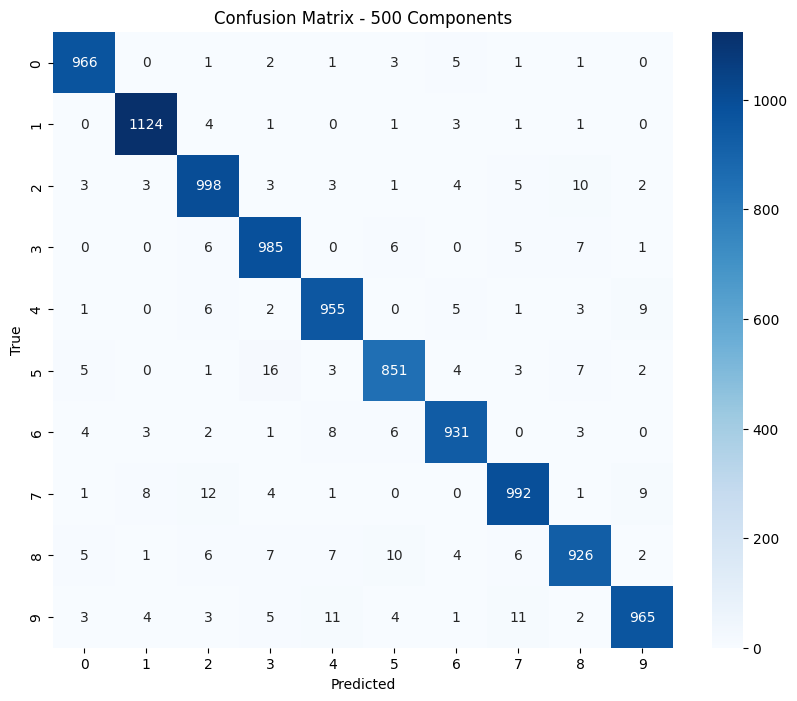


Performing PCA with 300 components...
Mean values range: -4.179403185844421e-08 to 4.0171167347580195e-08
Number of non-zero means: 713
Centered data range: -1.287180561036207 to 199.99749755890574
Number of non-zero elements in centered data: 28520000
Covariance matrix shape: (784, 784)
Covariance matrix range: -0.431502690559265 to 1.0000251106966305
Number of non-zero elements in covariance matrix: 508369
Is covariance matrix symmetric? True
Is covariance matrix positive semi-definite? True
Training MLP with 300 components...
Iteration 1, loss = 0.44800720
Iteration 2, loss = 0.15347153
Iteration 3, loss = 0.10534168
Iteration 4, loss = 0.07854991
Iteration 5, loss = 0.05604474
Iteration 6, loss = 0.03826942
Iteration 7, loss = 0.02815074
Iteration 8, loss = 0.02425551
Iteration 9, loss = 0.02579273
Iteration 10, loss = 0.01546193
Iteration 11, loss = 0.01732476
Iteration 12, loss = 0.01575121
Iteration 13, loss = 0.00918775
Iteration 14, loss = 0.01118766
Iteration 15, loss = 0.01

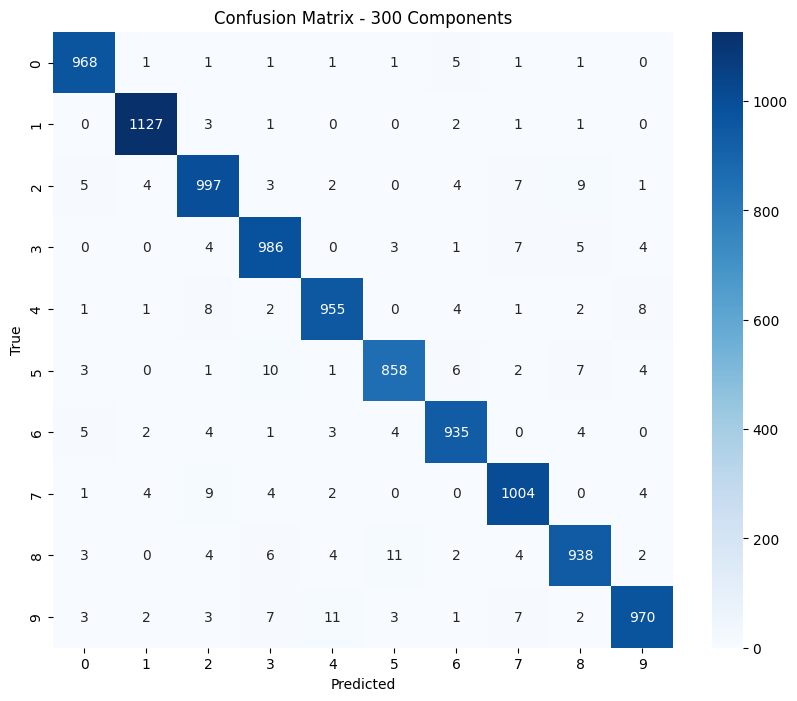


Performing PCA with 150 components...
Mean values range: -4.179403185844421e-08 to 4.0171167347580195e-08
Number of non-zero means: 713
Centered data range: -1.287180561036207 to 199.99749755890574
Number of non-zero elements in centered data: 28520000
Covariance matrix shape: (784, 784)
Covariance matrix range: -0.431502690559265 to 1.0000251106966305
Number of non-zero elements in covariance matrix: 508369
Is covariance matrix symmetric? True
Is covariance matrix positive semi-definite? True
Training MLP with 150 components...
Iteration 1, loss = 0.42905733
Iteration 2, loss = 0.16488398
Iteration 3, loss = 0.11530965
Iteration 4, loss = 0.08308985
Iteration 5, loss = 0.06439758
Iteration 6, loss = 0.05370404
Iteration 7, loss = 0.03987052
Iteration 8, loss = 0.03281972
Iteration 9, loss = 0.02598139
Iteration 10, loss = 0.02104894
Iteration 11, loss = 0.02201307
Iteration 12, loss = 0.01838024
Iteration 13, loss = 0.01770682
Iteration 14, loss = 0.01166318
Iteration 15, loss = 0.00

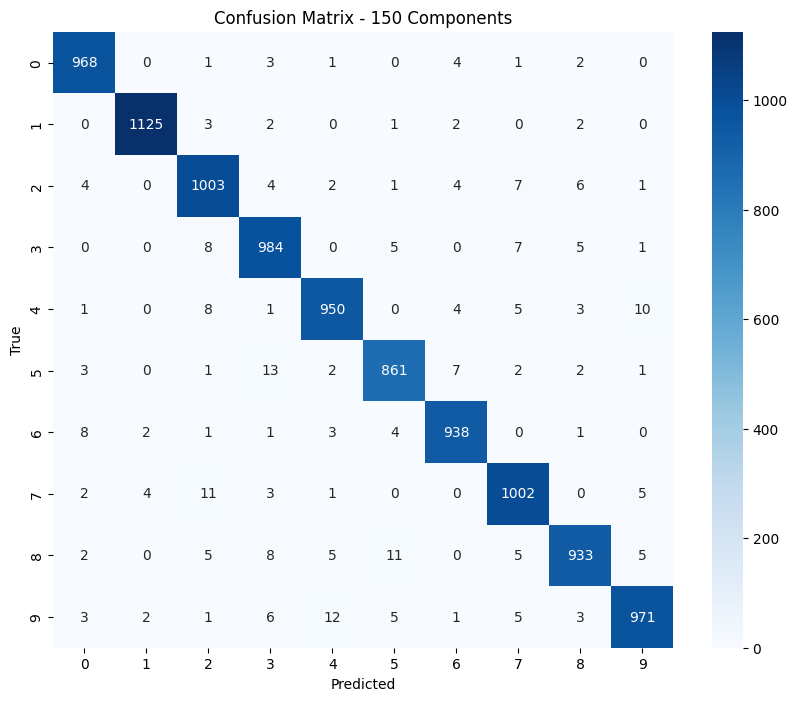


Performing PCA with 30 components...
Mean values range: -4.179403185844421e-08 to 4.0171167347580195e-08
Number of non-zero means: 713
Centered data range: -1.287180561036207 to 199.99749755890574
Number of non-zero elements in centered data: 28520000
Covariance matrix shape: (784, 784)
Covariance matrix range: -0.431502690559265 to 1.0000251106966305
Number of non-zero elements in covariance matrix: 508369
Is covariance matrix symmetric? True
Is covariance matrix positive semi-definite? True
Training MLP with 30 components...
Iteration 1, loss = 0.42250492
Iteration 2, loss = 0.17220632
Iteration 3, loss = 0.12743393
Iteration 4, loss = 0.10685210
Iteration 5, loss = 0.09247945
Iteration 6, loss = 0.07867337
Iteration 7, loss = 0.06972877
Iteration 8, loss = 0.06198623
Iteration 9, loss = 0.05851044
Iteration 10, loss = 0.05439898
Iteration 11, loss = 0.04820553
Iteration 12, loss = 0.04317360
Iteration 13, loss = 0.03917135
Iteration 14, loss = 0.03620392
Iteration 15, loss = 0.0318

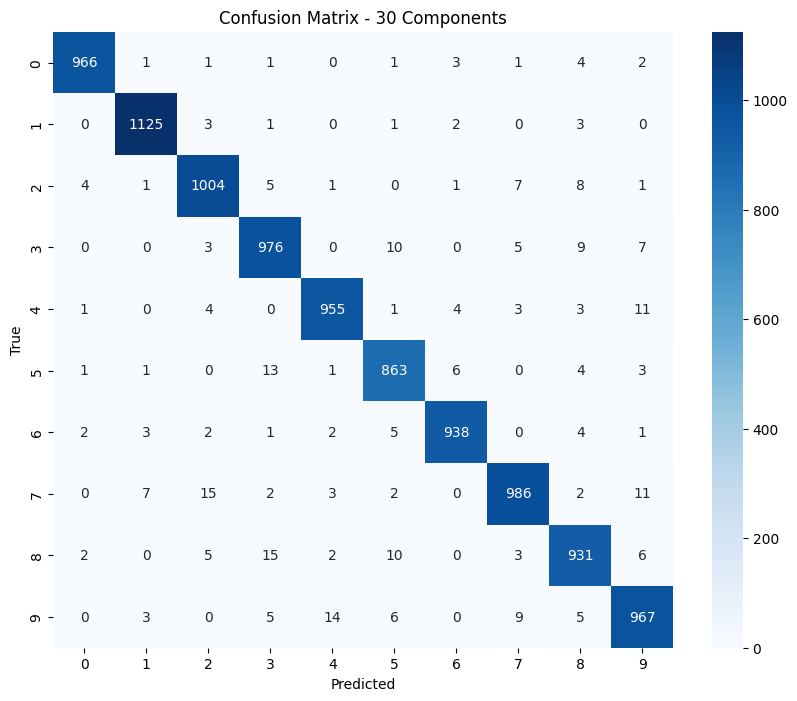

In [57]:
dimensions = [500, 300, 150, 30]
for dim in dimensions:
    print(f"\nPerforming PCA with {dim} components...")
    X_train_pca, X_test_pca = perform_pca(X_train, X_test, dim)
    
    print(f"Training MLP with {dim} components...")
    mlp = MLPClassifier(**mlp_params)
    mlp.fit(X_train_pca, y_train)
    y_pred = mlp.predict(X_test_pca)
    
    metrics = evaluate_model(y_test, y_pred)
    results[dim] = metrics
    
    print(f"\nResults with {dim} components:")
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Weighted Precision: {metrics['weighted_precision']:.4f}")
    print(f"Weighted Recall: {metrics['weighted_recall']:.4f}")
    print("\nPer-class Precision:")
    for i, p in enumerate(metrics['per_class_precision']):
        print(f"Digit {i}: {p:.4f}")
    print("\nPer-class Recall:")
    for i, r in enumerate(metrics['per_class_recall']):
        print(f"Digit {i}: {r:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dim} Components')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

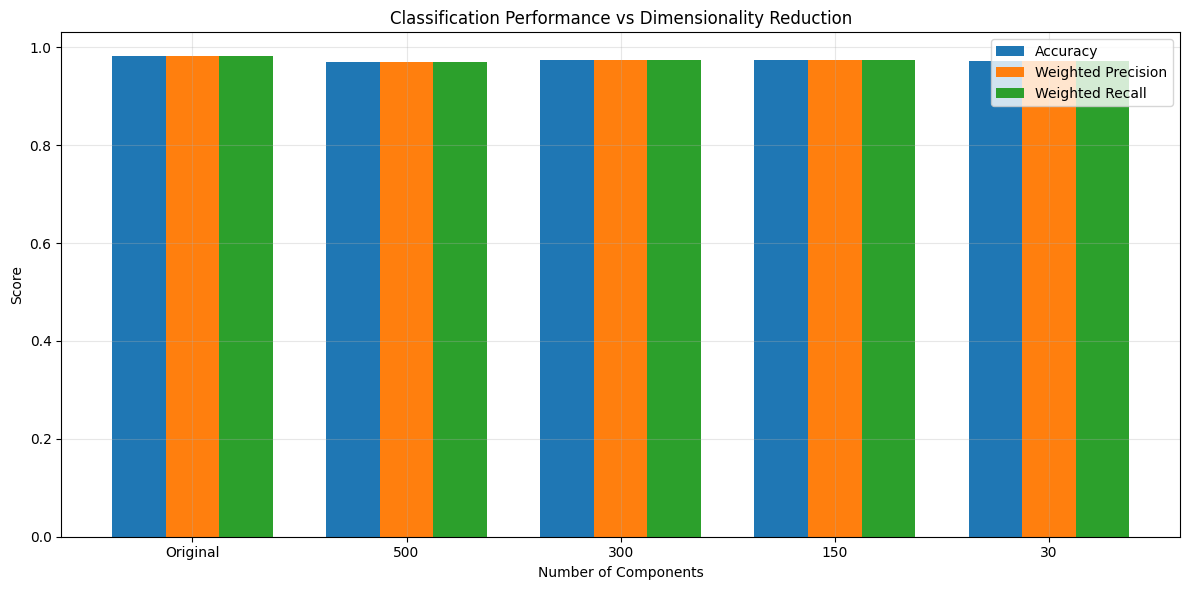

In [70]:
metrics_to_plot = ['accuracy', 'weighted_precision', 'weighted_recall']
plt.figure(figsize=(12, 6))
x_labels = ['Original'] + [f'{dim}' for dim in dimensions]
x = np.arange(len(x_labels))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    values = [results['original'][metric]] + [results[dim][metric] for dim in dimensions]
    metric_label = metric.replace('_', ' ').title()  # Format the label nicely
    plt.bar(x + i*width, values, width, label=metric_label)

plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Classification Performance vs Dimensionality Reduction')
plt.xticks(x + width, x_labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [69]:
print("\nSummary of Results:")
print("Dimensions | Accuracy | Precision | Recall")
print("-" * 45)
print(f"Original  | {results['original']['accuracy']:.4f}  | {results['original']['weighted_precision']:.4f}   | {results['original']['weighted_recall']:.4f}")
for dim in dimensions:
    print(f"{dim:9d} | {results[dim]['accuracy']:.4f}  | {results[dim]['weighted_precision']:.4f}   | {results[dim]['weighted_recall']:.4f}")


Summary of Results:
Dimensions | Accuracy | Precision | Recall
---------------------------------------------
Original  | 0.9813  | 0.9813   | 0.9813
      500 | 0.9693  | 0.9693   | 0.9693
      300 | 0.9738  | 0.9738   | 0.9738
      150 | 0.9735  | 0.9735   | 0.9735
       30 | 0.9711  | 0.9711   | 0.9711


In [60]:
print("\nDetailed Summary of Results:")
print("\nOriginal Data:")
print("Digit | Precision | Recall")
print("-" * 30)
for i in range(10):
    print(f"{i:5d} | {results['original']['per_class_precision'][i]:.4f}   | {results['original']['per_class_recall'][i]:.4f}")

for dim in dimensions:
    print(f"\n{dim} Components:")
    print("Digit | Precision | Recall")
    print("-" * 30)
    for i in range(10):
        print(f"{i:5d} | {results[dim]['per_class_precision'][i]:.4f}   | {results[dim]['per_class_recall'][i]:.4f}") 


Detailed Summary of Results:

Original Data:
Digit | Precision | Recall
------------------------------
    0 | 0.9868   | 0.9888
    1 | 0.9903   | 0.9921
    2 | 0.9788   | 0.9835
    3 | 0.9736   | 0.9851
    4 | 0.9836   | 0.9776
    5 | 0.9908   | 0.9686
    6 | 0.9822   | 0.9812
    7 | 0.9759   | 0.9835
    8 | 0.9783   | 0.9702
    9 | 0.9734   | 0.9792

500 Components:
Digit | Precision | Recall
------------------------------
    0 | 0.9777   | 0.9857
    1 | 0.9834   | 0.9903
    2 | 0.9605   | 0.9671
    3 | 0.9600   | 0.9752
    4 | 0.9656   | 0.9725
    5 | 0.9649   | 0.9540
    6 | 0.9728   | 0.9718
    7 | 0.9678   | 0.9650
    8 | 0.9636   | 0.9507
    9 | 0.9747   | 0.9564

300 Components:
Digit | Precision | Recall
------------------------------
    0 | 0.9788   | 0.9878
    1 | 0.9877   | 0.9930
    2 | 0.9642   | 0.9661
    3 | 0.9657   | 0.9762
    4 | 0.9755   | 0.9725
    5 | 0.9750   | 0.9619
    6 | 0.9740   | 0.9760
    7 | 0.9710   | 0.9767
    8 | 0.9680   |

# 4.3 Report

### 4.1 Plots and images from the above tasks, with your observations. 

###  4.2 How does PCA help mitigate the curse of dimensionality? Can you think
of cases where PCA might not be effective in high-dimensional spaces?

## 4.3.2 PCA and the Curse of Dimensionality

### PCA helps mitigate the curse of dimensionality in several ways:

#### Dimension Reduction:
- Reduces data from high-dimensional to lower-dimensional space while preserving important variations
- As seen in MNIST (784 → 30 dimensions with 97% accuracy maintained)
- Reduces computational complexity and storage requirements

#### Feature Selection:
- Eliminates redundant or highly correlated features
- Focuses on directions of maximum variance
- Reduces noise in the data

#### Data Visualization:
- Makes high-dimensional data visualizable in 2D/3D
- Helps in understanding data patterns and clusters

### However, PCA might not be effective in these cases:

#### Nonlinear Relationships:
- PCA only captures linear relationships
- **Example:** Data points lying on a spiral in 3D space cannot be effectively reduced using PCA
- **Better alternatives:** Kernel PCA, t-SNE, or UMAP

#### Sparse Data:
- When data points are very sparse in high dimensions
- PCA might fail to find meaningful principal components
- **Example:** Text data with thousands of rare words

#### Categorical Features:
- PCA assumes continuous numerical features
- Not directly applicable to categorical data
- Requires special preprocessing

---

## 4.3.3 PCA's Maximum Variance Assumption

The assumption that directions of maximum variance are most informative can fail in several scenarios:

### Classification Example:
- **Scenario:**
  - Maximum variance is along the x-axis (horizontal spread)
  - But the discriminative information is along the y-axis (class separation)
  - PCA would prioritize the wrong direction

  ![PCA Plot](./pca_image.webp)

### Noise-Dominated Data:
- When noise has larger variance than the signal
- **Example:** EEG data where muscle artifacts have larger amplitude than brain signals
- PCA would preserve the noise and potentially lose the important signal

### Time Series Example:
- PCA would prioritize seasonal variations
- But the smaller pattern might contain the crucial information (like market trends in financial data)

### Scale-Dependent Features:
- When features are on different scales
- **Example:** Housing data with:
  - Price (100,000s of dollars)
  - Number of rooms (1-10)
- PCA would be dominated by price variations unless data is standardized

### Informative Outliers:
- When rare but important events have small variance
- **Example:** Fraud detection where fraudulent transactions are rare
- PCA might discard these important but low-variance patterns

### To address these limitations, alternatives include:
- Auto encoders
- Supervised dimensionality reduction (LDA)
- Robust PCA
- Kernel PCA
- Feature selection based on domain knowledge
- Regularized versions of PCA


## I wrote a blog on PCA, you can find it at [PCA Blog](https://medium.com/@vishnusathvik100/beautiful-math-behind-principle-component-analysis-0170ff62b2ae)